In [1]:
!pip install memory_profiler

In [3]:
import cv2
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import time
import memory_profiler
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
from torchvision.datasets import VOCDetection
# #downLoad Pascal VOC dataset
VOCDetection(root='VOC_data', year='2012', image_set='trainval', download=True)

100%|██████████| 2.00G/2.00G [01:19<00:00, 25.1MB/s]


Extracting VOC_data/VOCtrainval_11-May-2012.tar to VOC_data


Dataset VOCDetection
    Number of datapoints: 11540
    Root location: VOC_data

In [5]:
VOC_CLASSES_original = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

In [6]:
# Define VOC_CLASSES for segmentation
VOC_CLASSES = {
    "bicycle": 2, "bus": 6, "car": 7, "motorbike": 14, "person": 15
}
# Re-index values
VOC_CLASSES_ReIndex = {name: idx+1 for idx, (name, _) in enumerate(VOC_CLASSES.items())}
print(VOC_CLASSES_ReIndex)

{'bicycle': 1, 'bus': 2, 'car': 3, 'motorbike': 4, 'person': 5}


In [7]:
class Config:
    root_dir = '/content/VOC_data/VOCdevkit/VOC2012'
    #root_dir = 'VOC2012'
    num_epochs = 40
    batch_size = 6
    learning_rate = 0.005
    momentum = 0.9
    weight_decay = 0.0005
    #iou_threshold = 0.5
    patience = 10
    classes = VOC_CLASSES_ReIndex
    subset_size_class = 2273
    val_split = 0.25

In [8]:
# make subset class balanced
def getSubsetClassesMask(root, classes, image_set,  subset_size_class):
    image_dir = os.path.join(root, "JPEGImages")
    annotation_dir = os.path.join(root, "Annotations")
    image_set_file_img = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")
    image_set_file_mask = os.path.join(root, "ImageSets", "Segmentation", f"{image_set}.txt")  #

    # Read image mask ids
    with open(image_set_file_mask) as f:
        image_ids_mask = f.read().strip().split()

    tmp_ImgSet = []
    for imgSet in os.listdir(os.path.join(root, "ImageSets", "Main")):
        if imgSet.endswith(f"_{image_set}.txt"):
            subset_class = imgSet.split("_")[0]
            if str(subset_class) in classes:
                subset_class_path = os.path.join(root, "ImageSets", "Main", f"{subset_class}_{image_set}.txt")
                with open(subset_class_path) as f:
                    image_ids_img = [line.strip().split(" ")[0] for line in f.readlines()]
                    image_ids_inter = [x for x in image_ids_img if x in image_ids_mask] # intersection of list
                    #print(len(image_ids_inter))
                    image_ids = random.sample(image_ids_inter, subset_size_class) # make subset
                tmp_ImgSet.extend(image_ids)
    tmp_ImgSet = set(tmp_ImgSet)

    tmp = []
    for image_id in tmp_ImgSet:
        img_path = os.path.join(image_dir, f"{image_id}.jpg")
        annotation_path = os.path.join(annotation_dir, f"{image_id}.xml")

        tree = ET.parse(annotation_path)
        root_tree = tree.getroot()

        for obj in root_tree.iter('object'):
            class_name = obj.find('name').text
            if class_name in classes:
                tmp.append(image_id)

    subset=list(set(tmp)) #get unique file

    if image_set == 'trainval':

        subset_train, subset_val = train_test_split(subset, test_size=Config.val_split, random_state=42)
        print(f'{image_set} {len(subset)} images')
        print(f'train {len(subset_train)} images')
        print(f'val {len(subset_val)} images')

        new_set_file = os.path.join(root, "ImageSets", "Main", "train_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset_train:
                file.write(f"{value}\n")
        new_set_file = os.path.join(root, "ImageSets", "Main", "val_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset_val:
                file.write(f"{value}\n")
    else:
        print(f'{image_set} {len(subset)} images')
        new_set_file = os.path.join(root, "ImageSets", "Main", f"{image_set}_subsetBalanced.txt")
        with open(new_set_file, "w") as file:
            for value in subset:
                file.write(f"{value}\n")

In [9]:
# get subset classes
getSubsetClassesMask(root=Config.root_dir, classes=VOC_CLASSES, image_set='trainval', subset_size_class=Config.subset_size_class)
#getSubsetClassesMask(root=Config.root_dir, classes=VOC_CLASSES, image_set='train', subset_size_class=Config.subset_size_class)
#getSubsetClassesMask(root=Config.root_dir, classes=VOC_CLASSES, image_set='val', subset_size_class=int(Config.subset_size_class * 0.1))


trainval 908 images
train 681 images
val 227 images


In [14]:
# Define the model
def get_model(num_classes):
    # Load a pre-trained Mask R-CNN model with a ResNet-50 backbone
    model = maskrcnn_resnet50_fpn(
                weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT,
                weights_backbone=ResNet50_Weights.DEFAULT,
                trainable_backbone_layers=3)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # FastRCNNPredictor

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # Mask R-CNN mask predictor hidden layer size (default is 256)
    # Replace the mask predictor with new number of classes
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


In [15]:
# Load the Mask R-CNN model
model = get_model(len(Config.classes)+1)
model = model.to(device)

In [16]:
# fine tunned classes
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [17]:
# fine tunned classes
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))
)

In [18]:
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(trainable_params)

['backbone.body.layer2.0.conv1.weight', 'backbone.body.layer2.0.conv2.weight', 'backbone.body.layer2.0.conv3.weight', 'backbone.body.layer2.0.downsample.0.weight', 'backbone.body.layer2.1.conv1.weight', 'backbone.body.layer2.1.conv2.weight', 'backbone.body.layer2.1.conv3.weight', 'backbone.body.layer2.2.conv1.weight', 'backbone.body.layer2.2.conv2.weight', 'backbone.body.layer2.2.conv3.weight', 'backbone.body.layer2.3.conv1.weight', 'backbone.body.layer2.3.conv2.weight', 'backbone.body.layer2.3.conv3.weight', 'backbone.body.layer3.0.conv1.weight', 'backbone.body.layer3.0.conv2.weight', 'backbone.body.layer3.0.conv3.weight', 'backbone.body.layer3.0.downsample.0.weight', 'backbone.body.layer3.1.conv1.weight', 'backbone.body.layer3.1.conv2.weight', 'backbone.body.layer3.1.conv3.weight', 'backbone.body.layer3.2.conv1.weight', 'backbone.body.layer3.2.conv2.weight', 'backbone.body.layer3.2.conv3.weight', 'backbone.body.layer3.3.conv1.weight', 'backbone.body.layer3.3.conv2.weight', 'backbone.

In [19]:
trainable_params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params_count)

43721523


In [20]:
params = [param for name, param in model.named_parameters() if param.requires_grad]
len(params )

84

In [21]:
# transform original
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [18]:
# transform custom in model
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [22]:
class ResizeNormalizeTransform:
    def __init__(self, normalize=False, min_size=400, max_size=600, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

        self.normalize = normalize
        self.min_size = min_size
        self.max_size = max_size
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes, masks=None):
        # Get original size
        original_width, original_height = image.size

        # Calculate scaling factor to maintain aspect ratio
        min_original_size = float(min(original_width, original_height))
        max_original_size = float(max(original_width, original_height))

        # Calculate scale factor
        scale = self.min_size / min_original_size

        # Check if the scaling would make the longer side too big
        if scale * max_original_size > self.max_size:
            scale = self.max_size / max_original_size

        # Calculate new size
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize image
        image = T.Resize((new_height, new_width))(image)

        # Adjust bounding boxes
        if boxes is not None and len(boxes):
            boxes = boxes.clone()
            boxes[:, [0, 2]] *= (new_width / original_width)  # Scale x coordinates
            boxes[:, [1, 3]] *= (new_height / original_height)  # Scale y coordinates

        # Adjust masks if provided
        if masks is not None and len(masks):
            masks = torch.nn.functional.interpolate(
                masks.unsqueeze(1).float(),
                size=(new_height, new_width),
                mode="nearest"
            ).squeeze(1)

        # Convert to tensor and normalize
        image = T.ToTensor()(image)
        if self.normalize:
            image = T.Normalize(mean=self.mean, std=self.std)(image)

        return image, boxes, masks

# Instance transformation
transform = ResizeNormalizeTransform()


In [20]:
class VOCDataset(Dataset):
    def __init__(self, root, classes, image_set, transform=None):
        super().__init__()

        self.root = root
        self.classes = classes
        self.image_set = image_set
        self.transform = transform

        # Paths
        self.image_dir = os.path.join(root, "JPEGImages")
        self.annotation_dir = os.path.join(root, "Annotations")
        self.mask_dir = os.path.join(root, "SegmentationObject")
        # Load image ids
        self.image_set_file = os.path.join(root, "ImageSets", "Main", f"{image_set}_subsetBalanced.txt")

        with open(self.image_set_file) as f:
            self.image_ids = f.read().strip().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Load image
        img_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        # Load annotation and masks
        annot_path = os.path.join(self.annotation_dir, f"{image_id}.xml")
        mask_path = os.path.join(self.mask_dir, f"{image_id}.png")

        boxes, labels, masks = self._parse_voc_annotation(
            annot_path,
            mask_path,
            image.size[1],
            image.size[0]
        )

        # Apply transformations
        if self.transform:
            image, boxes, masks = self.transform(image, boxes, masks)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([idx])
        }

        return image, target, image_id

    def _parse_voc_annotation(self, xml_path, mask_path, height, width):
        # Parse XML annotation
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes, labels, object_ids, masks = [], [], [], []

        # Load instance segmentation mask
        if os.path.exists(mask_path):
            mask_array = np.array(Image.open(mask_path))
        else:
            mask_array = np.zeros((height, width), dtype=np.uint8)

        # Parse objects
        for obj_id, obj in enumerate(root.findall("object")):
            label = obj.find("name").text
            if label in self.classes:
                # Add label and box
                labels.append(self.classes[label])
                object_ids.append(obj_id + 1)  # VOC uses 1-based indexing

                bbox = obj.find("bndbox")
                box = [
                    float(bbox.find(coord).text)
                    for coord in ["xmin", "ymin", "xmax", "ymax"]
                ]
                boxes.append(box)

                # Create binary mask for this instance
                instance_mask = (mask_array == obj_id + 1).astype(np.uint8) # VOC uses 1-based indexing
                masks.append(instance_mask)

        # Convert to tensors
        if not boxes:
            return (
                torch.zeros((0, 4), dtype=torch.float32),
                torch.zeros((0,), dtype=torch.int64),
                torch.zeros((0, height, width), dtype=torch.uint8)
            )

        return (
            torch.tensor(boxes, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.int64),
            torch.stack([torch.from_numpy(m) for m in masks]) if masks else torch.zeros((0, height, width), dtype=torch.uint8) #stack
        )

In [21]:
# Instantiate datasets
train_dataset = VOCDataset(
    root=Config.root_dir,
    classes = Config.classes,
    image_set='train',
    transform=transform)

val_dataset = VOCDataset(
    root=Config.root_dir,
    classes = Config.classes,
    image_set='val',
    transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 681
Number of validation samples: 227


In [22]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=os.cpu_count(),
    pin_memory=True, # Faster data transfer to GPU
    prefetch_factor=2,
    persistent_workers=True
)

# Add prefetch_factor for better memory usage
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=os.cpu_count(),
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

print("Number of training loader:", len(train_loader))
print("Number of validation loader:", len(val_loader))

Number of training loader: 114
Number of validation loader: 38


In [23]:
# VOC_CLASSES_inverted
VOC_CLASSES_inverted = {v: k for k, v in VOC_CLASSES_ReIndex.items()}
print(VOC_CLASSES_inverted)

{1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}


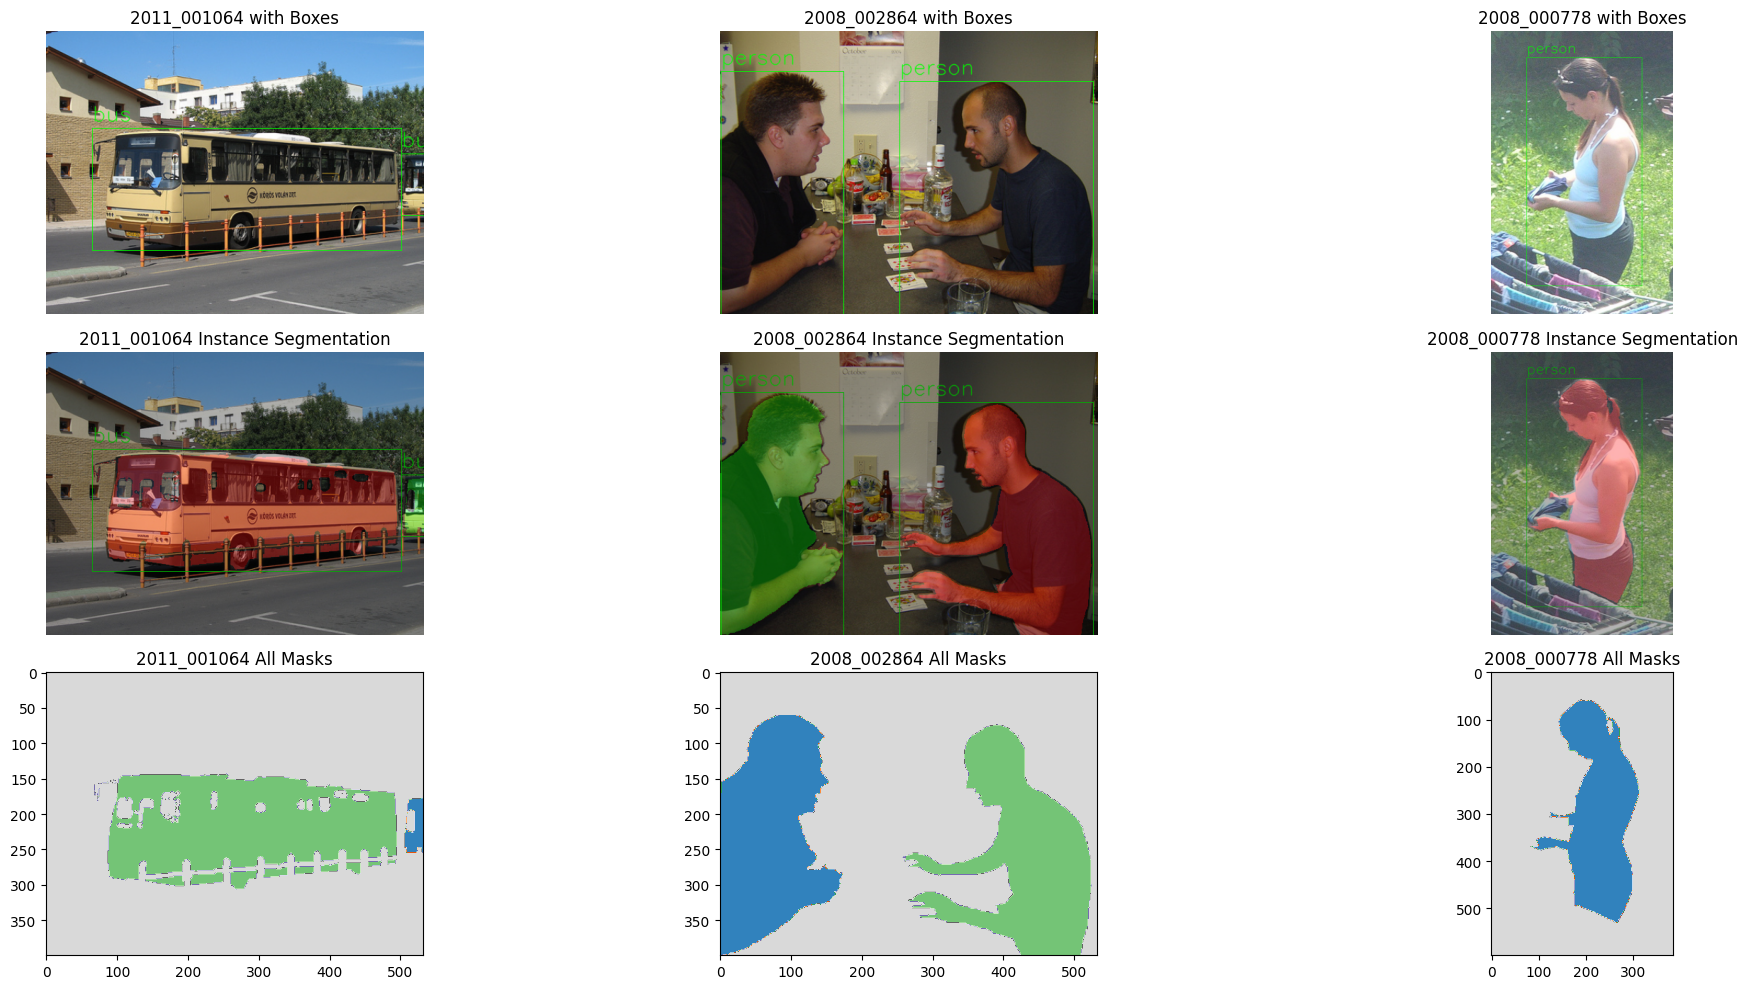

In [24]:
# visualize a batch of train data loader
images, target, filenames = next(iter(train_loader))
fig = plt.figure(figsize=(22, 10))
rows, cols = 3, 3

for i in range(cols):
    # Plot original image with boxes
    ax = fig.add_subplot(rows, cols, i+1)
    img = np.transpose(images[i], (1, 2, 0))
    img = img.detach().cpu().numpy()
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = target[i]['boxes']
    labels = target[i]['labels']
    masks = target[i]['masks']
    filename = filenames[i]

    # Loop through each box and label
    for j in range(len(boxes)):
        # Get coordinates for the rectangle
        x1, y1, x2, y2 = map(int, boxes[j])
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=1)

        class_id = int(labels[j])
        label_name = VOC_CLASSES_inverted.get(class_id, "Unknown")
        # Set the position for the label text (above the rectangle)
        text_position = (x1, y1 - 10 if y1 > 20 else y1 + 10)

        # Add the label text to the image
        cv2.putText(
            img,
            label_name,
            text_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (0, 255, 0), # Text color (same as rectangle color)
            thickness=1, # Thickness of text
            lineType=cv2.LINE_AA
        )

    ax.imshow(img)
    ax.set_title(f'{filename} with Boxes')
    ax.axis('off')

    # Plot individual masks
    ax = fig.add_subplot(rows, cols, i+cols+1)

    # Create a colored mask visualization
    mask_overlay = np.zeros_like(img)
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)]

    if len(masks) > 0:
        for j, mask in enumerate(masks):
            color = np.array(colors[j % len(colors)])
            mask_np = mask.numpy()[..., None]  # Add channel dimension
            mask_overlay += (mask_np * color.reshape(1, 1, 3)).astype(np.uint8)

    # Blend with original image
    final_img = cv2.addWeighted(img, 0.7, mask_overlay, 0.3, 0)
    ax.imshow(final_img)
    ax.set_title(f'{filename} Instance Segmentation')
    ax.axis('off')

    # Plot all masks separately
    ax = fig.add_subplot(rows, cols, i+2*cols+1)
    if len(masks) > 0:
        all_masks = np.zeros(masks[0].shape, dtype=np.float32)
        for j, mask in enumerate(masks):
            mask_np = mask.numpy()
            # Add each mask with a different value
            all_masks = np.maximum(all_masks, (j + 1) * mask_np)

        ax.imshow(all_masks, cmap='tab20c_r')
    else:
        ax.imshow(np.zeros((masks.shape[1], masks.shape[2])), cmap='tab20')

    ax.set_title(f'{filename} All Masks')
    ax.axis(True)

plt.tight_layout()
plt.show()

In [25]:
# check
def check_model_output(model, val_loader, device):
    model.eval()

    # Get one batch of data
    images, targets, _ = next(iter(val_loader))
    images = list(image.to(device) for image in images)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)

    # Print detailed information about the output
    print("Type of model output:", type(outputs))  # Should be list
    print("\nLength of outputs (batch size):", len(outputs))

    # Look at first prediction in batch
    first_pred = outputs[0]
    print("\nFirst prediction contains:")
    print("Keys:", first_pred.keys())  # Should show 'boxes', 'labels', 'scores', 'masks'

    print("\nDetailed structure:")
    print("Boxes shape:", first_pred['boxes'].shape)  # [N, 4] where N is number of detections
    print("Labels shape:", first_pred['labels'].shape)  # [N]
    print("Scores shape:", first_pred['scores'].shape)  # [N]
    print("Masks shape:", first_pred['masks'].shape)  # [N]

    # Print sample values
    print("\nSample values for first detection:")
    if len(first_pred['boxes']) > 0:
        print("Box coordinates (x1,y1,x2,y2):", first_pred['boxes'][0].tolist())
        print("Label:", first_pred['labels'][0].item())
        print("Confidence score:", first_pred['scores'][0].item())

    return outputs

# usage:
pred_output = check_model_output(model, val_loader, device)

Type of model output: <class 'list'>

Length of outputs (batch size): 6

First prediction contains:
Keys: dict_keys(['boxes', 'labels', 'scores', 'masks'])

Detailed structure:
Boxes shape: torch.Size([100, 4])
Labels shape: torch.Size([100])
Scores shape: torch.Size([100])
Masks shape: torch.Size([100, 1, 399, 600])

Sample values for first detection:
Box coordinates (x1,y1,x2,y2): [589.1256713867188, 230.34066772460938, 600.0, 265.8211364746094]
Label: 1
Confidence score: 0.40921148657798767


In [26]:
# Check
def check_target_format(val_loader):
    # Get one batch
    images, targets, _ = next(iter(val_loader))

    print("Target format:")
    print("Type of targets:", type(targets))
    print("Number of targets:", len(targets))

    # Look at first target
    first_target = targets[0]
    print("\nFirst target contains:")
    print("Keys:", first_target.keys())

    # Print shapes
    for key, value in first_target.items():
        print(f"{key} shape:", value.shape)
        print(f"Sample {key}:", value[0] if len(value) > 0 else "empty")

# Usage:
check_target_format(val_loader)

Target format:
Type of targets: <class 'list'>
Number of targets: 6

First target contains:
Keys: dict_keys(['boxes', 'labels', 'masks', 'image_id'])
boxes shape: torch.Size([3, 4])
Sample boxes: tensor([  1.2000,  41.9369, 562.8000, 399.0000])
labels shape: torch.Size([3])
Sample labels: tensor(5)
masks shape: torch.Size([3, 399, 600])
Sample masks: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
image_id shape: torch.Size([1])
Sample image_id: tensor(0)


## Metrics

In [27]:
# Calculate metrics
class InstanceSegmentationMetrics:
    def __init__(self, classes: Dict[str, int], iou_threshold: float = 0.5):
        self.classes = classes
        self.iou_threshold = iou_threshold
        self.reset()

    def reset(self):
        """Initialize metrics tracking"""
        self.metrics = {
            'per_class': {},
            'overall': {
                'mAP': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'bbox_iou': 0.0,
                'mask_iou': 0.0,
                'dice_coefficient': 0.0
            }
        }

        # Initialize per-class metrics
        for class_name in self.classes:
            self.metrics['per_class'][class_name] = {
                'tp': 0, 'fp': 0, 'fn': 0,
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'bbox_iou': 0.0,
                'mask_iou': 0.0,
                'dice_coefficient': 0.0
            }

    def calculate_iou(self, pred_boxes: torch.Tensor, gt_boxes: torch.Tensor) -> torch.Tensor:
        """Calculate Intersection over Union for bounding boxes"""
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            return torch.zeros((len(pred_boxes), len(gt_boxes)))

        # Compute areas of prediction and ground truth boxes
        area1 = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
        area2 = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])

        # Compute intersection coordinates
        lt = torch.max(pred_boxes[:, None, :2], gt_boxes[:, :2])
        rb = torch.min(pred_boxes[:, None, 2:], gt_boxes[:, 2:])

        # Compute intersection area
        wh = (rb - lt).clamp(min=0)
        inter = wh[:, :, 0] * wh[:, :, 1]

        # Compute union
        union = area1[:, None] + area2 - inter
        iou = inter / (union + 1e-8)

        return iou

    def calculate_mask_metrics(self, pred_mask: torch.Tensor, gt_mask: torch.Tensor) -> Dict[str, float]:
        """Calculate mask-specific metrics"""
        # Ensure masks are binary
        pred_binary = (pred_mask > 0.5).float()
        gt_binary = (gt_mask > 0.5).float()

        # Intersection and union
        intersection = (pred_binary * gt_binary).sum()
        union = (pred_binary + gt_binary).sum()

        # IoU (Jaccard Index)
        mask_iou = intersection / (union - intersection + 1e-8)

        # Dice Coefficient
        dice_coeff = 2 * intersection / (pred_binary.sum() + gt_binary.sum() + 1e-8)

        return {
            'mask_iou': mask_iou.item(),
            'dice_coefficient': dice_coeff.item()
        }

    def update_metrics(self, predictions: List[Dict], targets: List[Dict]):

        """Update metrics for a batch of predictions"""
        for pred, target in zip(predictions, targets):
            pred_boxes = pred['boxes']
            pred_labels = pred['labels']
            pred_scores = pred['scores']
            pred_masks = pred.get('masks', [])

            gt_boxes = target['boxes']
            gt_labels = target['labels']
            gt_masks = target.get('masks', [])

            # Calculate IoU matrix
            ious = self.calculate_iou(pred_boxes, gt_boxes)

            # Track matched ground truth
            matched_gt = set()

            # Process each prediction
            for i, (box, label, score) in enumerate(zip(pred_boxes, pred_labels, pred_scores)):
                best_match_idx = -1
                best_iou = 0.0

                # Find best matching ground truth
                for j, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                    if label == gt_label and ious[i, j] > best_iou:
                        best_match_idx = j
                        best_iou = ious[i, j]

                # Get class name
                class_name = list(self.classes.keys())[list(self.classes.values()).index(label.item())]
                class_metrics = self.metrics['per_class'][class_name]

                # Classify detection
                if best_match_idx != -1 and best_iou >= self.iou_threshold and best_match_idx not in matched_gt:
                    # True Positive
                    class_metrics['tp'] += 1
                    class_metrics['bbox_iou'] += best_iou.item()
                    matched_gt.add(best_match_idx)

                    # Mask metrics
                    if (pred_masks is not None and gt_masks is not None and
                        len(pred_masks) > 0 and len(gt_masks) > 0 and
                        i < len(pred_masks) and best_match_idx < len(gt_masks)):

                        pred_mask = pred_masks[i].squeeze().detach().cpu().numpy()
                        gt_mask = gt_masks[best_match_idx].squeeze().detach().cpu().numpy()

                        mask_metrics = self.calculate_mask_metrics(
                            torch.from_numpy(pred_mask),
                            torch.from_numpy(gt_mask)
                        )

                        class_metrics['mask_iou'] += mask_metrics['mask_iou']
                        class_metrics['dice_coefficient'] += mask_metrics['dice_coefficient']
                else:
                    # False Positive
                    class_metrics['fp'] += 1

            # Count False Negatives
            for j, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if j not in matched_gt:
                    class_name = list(self.classes.keys())[list(self.classes.values()).index(gt_label.item())]
                    self.metrics['per_class'][class_name]['fn'] += 1

    def compute_metrics(self):
        """Compute metrics"""
        for class_name, metrics in self.metrics['per_class'].items():
            tp = metrics['tp']
            fp = metrics['fp']
            fn = metrics['fn']

            # Precision, Recall, F1 Score
            metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            metrics['f1_score'] = (2 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'] + 1e-8)

            # Average IoU and Dice
            metrics['bbox_iou'] /= (tp + 1e-8)
            metrics['mask_iou'] /= (tp + 1e-8)
            metrics['dice_coefficient'] /= (tp + 1e-8)

        # Compute overall metrics
        overall = self.metrics['overall']
        per_class_metrics = self.metrics['per_class']

        overall['mAP'] = np.mean([metrics['precision'] for metrics in per_class_metrics.values()])
        overall['precision'] = overall['mAP']
        overall['recall'] = np.mean([metrics['recall'] for metrics in per_class_metrics.values()])
        overall['f1_score'] = np.mean([metrics['f1_score'] for metrics in per_class_metrics.values()])
        overall['bbox_iou'] = np.mean([metrics['bbox_iou'] for metrics in per_class_metrics.values()])
        overall['mask_iou'] = np.mean([metrics['mask_iou'] for metrics in per_class_metrics.values()])
        overall['dice_coefficient'] = np.mean([metrics['dice_coefficient'] for metrics in per_class_metrics.values()])

        return self.metrics

    def print_summary(self):
        """Print a summary of metrics"""
        metrics = self.metrics

        print("\n--- Overall Performance Metrics ---")
        for metric, value in metrics['overall'].items():
            print(f"{metric}: {value:.4f}")
        print("\n ")


### Plot functions

In [28]:
def plot_training_metrics(history):
    """Visualize training metrics"""
    fig = plt.figure(figsize=(22, 8))
    fig.suptitle('Training Metrics', fontsize=16)

    epochs = range(1, len(history['train_loss']) + 1)

    # Training Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # mAP Over Epochs
    plt.subplot(3, 2, 2)
    mAP_values = [metrics['overall']['mAP'] for metrics in history['val_metrics']]
    plt.plot(epochs, mAP_values)
    plt.title('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # IoU Metrics
    plt.subplot(3, 2, 3)
    bbox_iou = [metrics['overall']['bbox_iou'] for metrics in history['val_metrics']]
    mask_iou = [metrics['overall']['mask_iou'] for metrics in history['val_metrics']]
    plt.plot(epochs, bbox_iou, label='Bbox IoU')
    plt.plot(epochs, mask_iou, label='Mask IoU')
    plt.title('Intersection over Union')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Precision, Recall, F1 Score
    plt.subplot(3, 2, 4)
    precision = [metrics['overall']['precision'] for metrics in history['val_metrics']]
    recall = [metrics['overall']['recall'] for metrics in history['val_metrics']]
    f1_score = [metrics['overall']['f1_score'] for metrics in history['val_metrics']]
    dice = [metrics['overall']['dice_coefficient'] for metrics in history['val_metrics']]
    plt.plot(epochs, precision, label='Precision')
    plt.plot(epochs, recall, label='Recall')
    plt.plot(epochs, f1_score, label='F1 Score')
    plt.plot(epochs, dice, label='Dice Coefficient')
    plt.title('Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Per-class Performance
    plt.subplot(3, 2, 5)
    per_class_performance = [
        sum(metrics['per_class'][cls]['precision'] for cls in metrics['per_class']) / len(metrics['per_class'])
        for metrics in history['val_metrics']]
    plt.plot(epochs, per_class_performance)
    plt.title('Average Per-class Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Detection Performance
    plt.subplot(3, 2, 6)
    # Compute total tp, fp, fn for all classes at each epoch ##### revisar metrics['per_class'][cls]['tp'] for cls in metrics['per_class']
    total_tp_fp_fn_per_epoch = [
        {
            'tp': sum(metrics['per_class'][cls]['tp'] for cls in metrics['per_class']),
            'fp': sum(metrics['per_class'][cls]['fp'] for cls in metrics['per_class']),
            'fn': sum(metrics['per_class'][cls]['fn'] for cls in metrics['per_class'])
        }
        for metrics in history['val_metrics']]  # Iterate through epochs

    # Extract tp, fp, fn values for plotting
    tp_values = [epoch_metrics['tp'] for epoch_metrics in total_tp_fp_fn_per_epoch]
    fp_values = [epoch_metrics['fp'] for epoch_metrics in total_tp_fp_fn_per_epoch]
    fn_values = [epoch_metrics['fn'] for epoch_metrics in total_tp_fp_fn_per_epoch]

    plt.plot(epochs, tp_values, label='True Positives (TP)', marker='o')
    plt.plot(epochs, fp_values, label='False Positives (FP)', marker='s')
    plt.plot(epochs, fn_values, label='False Negatives (FN)', marker='^')

    plt.title('Detection Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
def compute_mean_metrics(val_metrics):
    """
    Compute the mean of metrics for each class across validation results.
    """
    # Initialize a dictionary to store cumulative sums
    metric_sums = {}
    num_entries = len(val_metrics)

    for entry in val_metrics:
        per_class = entry['per_class']
        for class_name, metrics in per_class.items():
            if class_name not in metric_sums:
                # Initialize the dictionary for the class with zero values
                metric_sums[class_name] = {metric: 0.0 for metric in metrics.keys()}

            # Add the metrics to the cumulative sums
            for metric, value in metrics.items():
                metric_sums[class_name][metric] += value

    # Compute the averages
    mean_metrics = {}
    for class_name, metrics in metric_sums.items():
        mean_metrics[class_name] = {metric: value / num_entries for metric, value in metrics.items()}

    return mean_metrics

In [30]:
def plot_metrics_per_class(history_metrics):
    """
    Visualize mean metrics across validation results per class.
    """
    # Metrics to plot
    metrics_to_plot = [
        'precision', 'recall', 'f1_score',
        'bbox_iou', 'mask_iou', 'dice_coefficient'
    ]

    # compute
    mean_metrics = compute_mean_metrics(history_metrics)

    # Extract class names
    class_names = list(mean_metrics.keys())

    # Set up the figure for plotting
    fig, axs = plt.subplots(1, 6, figsize=(22, 5))  # 1 row, 6 columns
    fig.suptitle('Mean Instance Segmentation Metrics by Class')

    for i, metric in enumerate(metrics_to_plot):
        # Extract mean values for the current metric
        class_values = [mean_metrics[class_name][metric] for class_name in class_names]

        # Create bar plot
        axs[i].bar(class_names, class_values, color='skyblue')
        axs[i].set_title(metric.replace('_', ' ').title())

        # Rotate x-axis labels for readability
        axs[i].set_xticks(range(len(class_names)))
        axs[i].set_xticklabels(class_names, rotation=45)

    plt.tight_layout()
    plt.show()


## Train Process

In [31]:
def track_performance(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = memory_profiler.memory_usage()[0]

        result = func(*args, **kwargs)

        end_time = time.time()
        end_memory = memory_profiler.memory_usage()[0]

        print(f"Function: {func.__name__}")
        print(f"Execution Time: {((end_time - start_time)/60):.2f} minutes")
        print(f"Memory Usage: {end_memory - start_memory:.2f} MB")

        return result
    return wrapper

In [32]:
@track_performance
def train_one_epoch(model, optimizer, train_loader, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch", desc="Training", leave=True, bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}') as tepoch:
        for images, targets, _ in tepoch:
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Clear gradients before forward pass
            optimizer.zero_grad()
            # Forward pass
            loss_dict = model(images, targets)
            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            # Backward pass
            losses.backward()
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Update weights
            optimizer.step()
            # Update total loss
            total_loss += losses.item()

            tepoch.set_postfix(loss=losses.item())

    return total_loss / len(train_loader)


In [33]:
@track_performance
def evaluate(model, val_loader, device, classes):
    """Evaluate the model on validation dataset"""
    model.eval()
    # Initialize metrics tracker
    metrics_tracker = InstanceSegmentationMetrics(classes=classes)

    with torch.no_grad():
        for images, targets, _ in tqdm(val_loader, desc="Eval", leave=False, bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}'):
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Get predictions
            outputs = model(images)
            # Update metrics
            metrics_tracker.update_metrics(outputs, targets)

    # Compute and return metrics
    metrics = metrics_tracker.compute_metrics()
    #metrics_tracker.print_summary()
    return metrics

In [34]:
@track_performance
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, save_path='./checkpoints'):
    """model training process"""
    os.makedirs(save_path, exist_ok=True)

    # Initialize tracking variables
    best_metrics = {
        'mAP': 0.0,
        'bbox_iou': 0.0,
        'mask_iou': 0.0
    }
    # History tracking
    history = {
        'train_loss': [],
        'val_metrics': []
    }
   # Early stopping
    patience = Config.patience
    patience_counter = 0

    for epoch in range(num_epochs):

        # Training phase
        train_loss = train_one_epoch(model, optimizer, train_loader, device)
        # Validation phase
        val_metrics = evaluate(model, val_loader, device, Config.classes)

        # Update history
        history['train_loss'].append(train_loss)
        history['val_metrics'].append(val_metrics)

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation mAP: {val_metrics['overall']['mAP']:.4f}")
        print(f"Validation Bbox IoU: {val_metrics['overall']['bbox_iou']:.4f}")
        print(f"Validation Mask IoU: {val_metrics['overall']['mask_iou']:.4f}")

        # Model checkpointing
        current_map = val_metrics['overall']['mAP']
        current_bbox_iou = val_metrics['overall']['bbox_iou']
        current_mask_iou = val_metrics['overall']['mask_iou']

        # Early stopping and model saving
        if current_map > best_metrics['mAP']:
            patience_counter = 0
            best_metrics['mAP'] = current_map
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': history
            }, f"{save_path}/best_map_model_maskRCNN.pth")
            print(f"New best model saved with mAP: {current_map:.4f}")
        else:
            patience_counter += 1
            print(f'patience_counter: {patience_counter}')

        if current_bbox_iou > best_metrics['bbox_iou']:
            best_metrics['bbox_iou'] = current_bbox_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': history
            }, f"{save_path}/best_model_maskRCNN.pth")
            print(f"New best model saved with bbox: {current_bbox_iou:.4f}")

        if current_mask_iou > best_metrics['mask_iou']:
            best_metrics['mask_iou'] = current_mask_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': history
            }, f"{save_path}/best_model_maskRCNN.pth")
            print(f"New best model saved with mask: {current_mask_iou:.4f}")

        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': history
            }, f"{save_path}/model_epoch_{epoch+1}_maskRCNN.pth")
            print(f"New model saved at epoch: {epoch:.4f}")

        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(current_map)
        else:
            scheduler.step()

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return model, history


### Run Train process

In [23]:
# Learning Rate Warmup
def get_lr_scheduler(optimizer, num_epochs):
    """Create learning rate scheduler with warmup"""
    def lr_lambda(epoch):
        if epoch < 5:  # Warmup for first 3 epochs
            return (epoch + 1) / 5
        # Exponential decay after peak learning
        return 0.95 ** (epoch - 5)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [24]:
# Prepare optimizer and scheduler
params = [param for name, param in model.named_parameters() if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=Config.learning_rate, momentum=Config.momentum, weight_decay=Config.weight_decay)
#optimizer = torch.optim.Adam(params, lr=Config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
#scheduler = get_lr_scheduler(optimizer, Config.num_epochs)
# cosine annealing scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)


In [ ]:
# Train the model
model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    Config.num_epochs,
    device
)

Train100%|██████████████████████████████████████████████████| 114/114 [04:19<00:00,  2.28s/batch, loss=0.852]


Function: train_one_epoch
Execution Time: 4.33 minutes
Memory Usage: 511.82 MB


Function: evaluate
Execution Time: 0.73 minutes
Memory Usage: 20.89 MB

Epoch 1/50
Training Loss: 1.0938
Validation mAP: 0.0614
Validation Bbox IoU: 0.7620
Validation Mask IoU: 0.6094
New best model saved with mAP: 0.0614
New best model saved with bbox: 0.7620
New best model saved with mask: 0.6094


Train100%|██████████████████████████████████████████████████| 114/114 [04:24<00:00,  2.32s/batch, loss=0.215]


Function: train_one_epoch
Execution Time: 4.41 minutes
Memory Usage: 39.14 MB


Function: evaluate
Execution Time: 0.68 minutes
Memory Usage: 12.07 MB

Epoch 2/50
Training Loss: 0.5079
Validation mAP: 0.1584
Validation Bbox IoU: 0.8011
Validation Mask IoU: 0.6378
New best model saved with mAP: 0.1584
New best model saved with bbox: 0.8011
New best model saved with mask: 0.6378


Train100%|██████████████████████████████████████████████████| 114/114 [04:31<00:00,  2.38s/batch, loss=0.434]


Function: train_one_epoch
Execution Time: 4.52 minutes
Memory Usage: 22.95 MB


Function: evaluate
Execution Time: 0.67 minutes
Memory Usage: 14.85 MB

Epoch 3/50
Training Loss: 0.4258
Validation mAP: 0.1678
Validation Bbox IoU: 0.8157
Validation Mask IoU: 0.6403
New best model saved with mAP: 0.1678
New best model saved with bbox: 0.8157
New best model saved with mask: 0.6403


Train100%|██████████████████████████████████████████████████| 114/114 [04:22<00:00,  2.30s/batch, loss=0.277]


Function: train_one_epoch
Execution Time: 4.38 minutes
Memory Usage: 15.82 MB


Function: evaluate
Execution Time: 0.67 minutes
Memory Usage: 6.92 MB

Epoch 4/50
Training Loss: 0.3831
Validation mAP: 0.2170
Validation Bbox IoU: 0.8230
Validation Mask IoU: 0.6335
New best model saved with mAP: 0.2170
New best model saved with bbox: 0.8230


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.34s/batch, loss=0.389]


Function: train_one_epoch
Execution Time: 4.45 minutes
Memory Usage: 15.18 MB


Function: evaluate
Execution Time: 0.66 minutes
Memory Usage: 8.54 MB

Epoch 5/50
Training Loss: 0.3520
Validation mAP: 0.2358
Validation Bbox IoU: 0.8225
Validation Mask IoU: 0.6471
New best model saved with mAP: 0.2358
New best model saved with mask: 0.6471
New model saved at epoch: 4.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:29<00:00,  2.36s/batch, loss=0.366]


Function: train_one_epoch
Execution Time: 4.49 minutes
Memory Usage: 2.58 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.11 MB

Epoch 6/50
Training Loss: 0.3272
Validation mAP: 0.2857
Validation Bbox IoU: 0.8249
Validation Mask IoU: 0.6635
New best model saved with mAP: 0.2857
New best model saved with bbox: 0.8249
New best model saved with mask: 0.6635


Train100%|██████████████████████████████████████████████████| 114/114 [04:23<00:00,  2.31s/batch, loss=0.184]


Function: train_one_epoch
Execution Time: 4.39 minutes
Memory Usage: 9.85 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: -0.35 MB

Epoch 7/50
Training Loss: 0.3080
Validation mAP: 0.2884
Validation Bbox IoU: 0.8323
Validation Mask IoU: 0.6619
New best model saved with mAP: 0.2884
New best model saved with bbox: 0.8323


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.36s/batch, loss=0.373]


Function: train_one_epoch
Execution Time: 4.48 minutes
Memory Usage: 10.83 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.05 MB

Epoch 8/50
Training Loss: 0.2955
Validation mAP: 0.3556
Validation Bbox IoU: 0.8223
Validation Mask IoU: 0.6645
New best model saved with mAP: 0.3556
New best model saved with mask: 0.6645


Train100%|██████████████████████████████████████████████████| 114/114 [04:26<00:00,  2.34s/batch, loss=0.356]


Function: train_one_epoch
Execution Time: 4.44 minutes
Memory Usage: 6.70 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: -0.15 MB

Epoch 9/50
Training Loss: 0.2780
Validation mAP: 0.3455
Validation Bbox IoU: 0.8282
Validation Mask IoU: 0.6729
patience_counter: 1
New best model saved with mask: 0.6729


Train100%|██████████████████████████████████████████████████| 114/114 [04:25<00:00,  2.33s/batch, loss=0.279]


Function: train_one_epoch
Execution Time: 4.43 minutes
Memory Usage: 5.41 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 1.30 MB

Epoch 10/50
Training Loss: 0.2706
Validation mAP: 0.3775
Validation Bbox IoU: 0.8341
Validation Mask IoU: 0.6777
New best model saved with mAP: 0.3775
New best model saved with bbox: 0.8341
New best model saved with mask: 0.6777
New model saved at epoch: 9.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:29<00:00,  2.36s/batch, loss=0.452]


Function: train_one_epoch
Execution Time: 4.49 minutes
Memory Usage: 7.36 MB


Function: evaluate
Execution Time: 0.67 minutes
Memory Usage: 10.33 MB

Epoch 11/50
Training Loss: 0.2621
Validation mAP: 0.4126
Validation Bbox IoU: 0.8335
Validation Mask IoU: 0.6882
New best model saved with mAP: 0.4126
New best model saved with mask: 0.6882


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.35s/batch, loss=0.25]


Function: train_one_epoch
Execution Time: 4.46 minutes
Memory Usage: 5.16 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 1.42 MB

Epoch 12/50
Training Loss: 0.2500
Validation mAP: 0.4056
Validation Bbox IoU: 0.8289
Validation Mask IoU: 0.6692
patience_counter: 1


Train100%|██████████████████████████████████████████████████| 114/114 [04:22<00:00,  2.30s/batch, loss=0.255]


Function: train_one_epoch
Execution Time: 4.38 minutes
Memory Usage: 5.29 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 1.27 MB

Epoch 13/50
Training Loss: 0.2430
Validation mAP: 0.3973
Validation Bbox IoU: 0.8345
Validation Mask IoU: 0.6783
patience_counter: 2
New best model saved with bbox: 0.8345


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.35s/batch, loss=0.336]


Function: train_one_epoch
Execution Time: 4.46 minutes
Memory Usage: 3.38 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 14/50
Training Loss: 0.2398
Validation mAP: 0.3815
Validation Bbox IoU: 0.8256
Validation Mask IoU: 0.6707
patience_counter: 3


Train100%|██████████████████████████████████████████████████| 114/114 [04:25<00:00,  2.33s/batch, loss=0.237]


Function: train_one_epoch
Execution Time: 4.42 minutes
Memory Usage: 3.87 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 15/50
Training Loss: 0.2312
Validation mAP: 0.4359
Validation Bbox IoU: 0.8303
Validation Mask IoU: 0.6774
New best model saved with mAP: 0.4359
New model saved at epoch: 14.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:33<00:00,  2.40s/batch, loss=0.186]


Function: train_one_epoch
Execution Time: 4.56 minutes
Memory Usage: 2.06 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 16/50
Training Loss: 0.2260
Validation mAP: 0.4100
Validation Bbox IoU: 0.8317
Validation Mask IoU: 0.6958
patience_counter: 1
New best model saved with mask: 0.6958


Train100%|██████████████████████████████████████████████████| 114/114 [04:26<00:00,  2.34s/batch, loss=0.198]


Function: train_one_epoch
Execution Time: 4.44 minutes
Memory Usage: 3.61 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 1.20 MB

Epoch 17/50
Training Loss: 0.2234
Validation mAP: 0.4548
Validation Bbox IoU: 0.8334
Validation Mask IoU: 0.6766
New best model saved with mAP: 0.4548


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.35s/batch, loss=0.364]


Function: train_one_epoch
Execution Time: 4.47 minutes
Memory Usage: 17.55 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 18/50
Training Loss: 0.2187
Validation mAP: 0.4532
Validation Bbox IoU: 0.8375
Validation Mask IoU: 0.6818
patience_counter: 1
New best model saved with bbox: 0.8375


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.35s/batch, loss=0.203]


Function: train_one_epoch
Execution Time: 4.47 minutes
Memory Usage: 5.67 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.00 MB

Epoch 19/50
Training Loss: 0.2130
Validation mAP: 0.4244
Validation Bbox IoU: 0.8352
Validation Mask IoU: 0.6828
patience_counter: 2


Train100%|██████████████████████████████████████████████████| 114/114 [04:30<00:00,  2.37s/batch, loss=0.198]


Function: train_one_epoch
Execution Time: 4.51 minutes
Memory Usage: 0.26 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.01 MB

Epoch 20/50
Training Loss: 0.2120
Validation mAP: 0.4651
Validation Bbox IoU: 0.8345
Validation Mask IoU: 0.6840
New best model saved with mAP: 0.4651
New model saved at epoch: 19.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.34s/batch, loss=0.236]


Function: train_one_epoch
Execution Time: 4.45 minutes
Memory Usage: 0.52 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 21/50
Training Loss: 0.2061
Validation mAP: 0.4719
Validation Bbox IoU: 0.8359
Validation Mask IoU: 0.6783
New best model saved with mAP: 0.4719


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.35s/batch, loss=0.252]


Function: train_one_epoch
Execution Time: 4.47 minutes
Memory Usage: 2.06 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 3.55 MB

Epoch 22/50
Training Loss: 0.2034
Validation mAP: 0.4723
Validation Bbox IoU: 0.8271
Validation Mask IoU: 0.6950
New best model saved with mAP: 0.4723


Train100%|██████████████████████████████████████████████████| 114/114 [04:31<00:00,  2.38s/batch, loss=0.241]


Function: train_one_epoch
Execution Time: 4.53 minutes
Memory Usage: 3.35 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 23/50
Training Loss: 0.2013
Validation mAP: 0.4987
Validation Bbox IoU: 0.8266
Validation Mask IoU: 0.6768
New best model saved with mAP: 0.4987


Train100%|██████████████████████████████████████████████████| 114/114 [04:29<00:00,  2.36s/batch, loss=0.162]


Function: train_one_epoch
Execution Time: 4.49 minutes
Memory Usage: 0.77 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 24/50
Training Loss: 0.1998
Validation mAP: 0.4885
Validation Bbox IoU: 0.8312
Validation Mask IoU: 0.6940
patience_counter: 1


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.36s/batch, loss=0.296]


Function: train_one_epoch
Execution Time: 4.48 minutes
Memory Usage: 1.86 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 25/50
Training Loss: 0.1968
Validation mAP: 0.4775
Validation Bbox IoU: 0.8420
Validation Mask IoU: 0.6875
patience_counter: 2
New best model saved with bbox: 0.8420
New model saved at epoch: 24.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:30<00:00,  2.37s/batch, loss=0.115]


Function: train_one_epoch
Execution Time: 4.51 minutes
Memory Usage: 5.16 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.52 MB

Epoch 26/50
Training Loss: 0.1929
Validation mAP: 0.4872
Validation Bbox IoU: 0.8334
Validation Mask IoU: 0.6887
patience_counter: 3


Train100%|██████████████████████████████████████████████████| 114/114 [04:24<00:00,  2.32s/batch, loss=0.176]


Function: train_one_epoch
Execution Time: 4.41 minutes
Memory Usage: 4.90 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 4.86 MB

Epoch 27/50
Training Loss: 0.1888
Validation mAP: 0.4603
Validation Bbox IoU: 0.8354
Validation Mask IoU: 0.6958
patience_counter: 4
New best model saved with mask: 0.6958


Train100%|██████████████████████████████████████████████████| 114/114 [04:23<00:00,  2.31s/batch, loss=0.174]


Function: train_one_epoch
Execution Time: 4.39 minutes
Memory Usage: 2.50 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 28/50
Training Loss: 0.1820
Validation mAP: 0.5010
Validation Bbox IoU: 0.8351
Validation Mask IoU: 0.6837
New best model saved with mAP: 0.5010


Train100%|██████████████████████████████████████████████████| 114/114 [04:30<00:00,  2.37s/batch, loss=0.15]


Function: train_one_epoch
Execution Time: 4.51 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 29/50
Training Loss: 0.1766
Validation mAP: 0.5127
Validation Bbox IoU: 0.8343
Validation Mask IoU: 0.6843
New best model saved with mAP: 0.5127


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.36s/batch, loss=0.149]


Function: train_one_epoch
Execution Time: 4.48 minutes
Memory Usage: 3.87 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.21 MB

Epoch 30/50
Training Loss: 0.1725
Validation mAP: 0.5208
Validation Bbox IoU: 0.8343
Validation Mask IoU: 0.6847
New best model saved with mAP: 0.5208
New model saved at epoch: 29.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.34s/batch, loss=0.138]


Function: train_one_epoch
Execution Time: 4.45 minutes
Memory Usage: 0.52 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 31/50
Training Loss: 0.1700
Validation mAP: 0.5238
Validation Bbox IoU: 0.8351
Validation Mask IoU: 0.6852
New best model saved with mAP: 0.5238


Train100%|██████████████████████████████████████████████████| 114/114 [04:29<00:00,  2.36s/batch, loss=0.0775]


Function: train_one_epoch
Execution Time: 4.49 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.64 minutes
Memory Usage: 0.00 MB

Epoch 32/50
Training Loss: 0.1698
Validation mAP: 0.5301
Validation Bbox IoU: 0.8365
Validation Mask IoU: 0.6853
New best model saved with mAP: 0.5301


Train100%|██████████████████████████████████████████████████| 114/114 [04:24<00:00,  2.32s/batch, loss=0.285]


Function: train_one_epoch
Execution Time: 4.42 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.64 minutes
Memory Usage: 0.00 MB

Epoch 33/50
Training Loss: 0.1697
Validation mAP: 0.5172
Validation Bbox IoU: 0.8368
Validation Mask IoU: 0.6874
patience_counter: 1


Train100%|██████████████████████████████████████████████████| 114/114 [04:26<00:00,  2.34s/batch, loss=0.222]


Function: train_one_epoch
Execution Time: 4.45 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 34/50
Training Loss: 0.1677
Validation mAP: 0.5420
Validation Bbox IoU: 0.8336
Validation Mask IoU: 0.6794
New best model saved with mAP: 0.5420


Train100%|██████████████████████████████████████████████████| 114/114 [04:29<00:00,  2.36s/batch, loss=0.153]


Function: train_one_epoch
Execution Time: 4.49 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 35/50
Training Loss: 0.1674
Validation mAP: 0.5441
Validation Bbox IoU: 0.8353
Validation Mask IoU: 0.6846
New best model saved with mAP: 0.5441
New model saved at epoch: 34.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:25<00:00,  2.33s/batch, loss=0.109]


Function: train_one_epoch
Execution Time: 4.43 minutes
Memory Usage: 0.52 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 36/50
Training Loss: 0.1662
Validation mAP: 0.5508
Validation Bbox IoU: 0.8370
Validation Mask IoU: 0.6899
New best model saved with mAP: 0.5508


Train100%|██████████████████████████████████████████████████| 114/114 [04:32<00:00,  2.39s/batch, loss=0.161]


Function: train_one_epoch
Execution Time: 4.54 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.64 minutes
Memory Usage: 0.23 MB

Epoch 37/50
Training Loss: 0.1661
Validation mAP: 0.5435
Validation Bbox IoU: 0.8334
Validation Mask IoU: 0.6847
patience_counter: 1


Train100%|██████████████████████████████████████████████████| 114/114 [04:30<00:00,  2.38s/batch, loss=0.16]


Function: train_one_epoch
Execution Time: 4.51 minutes
Memory Usage: 0.26 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 0.00 MB

Epoch 38/50
Training Loss: 0.1654
Validation mAP: 0.5419
Validation Bbox IoU: 0.8365
Validation Mask IoU: 0.6843
patience_counter: 2


Train100%|██████████████████████████████████████████████████| 114/114 [04:28<00:00,  2.36s/batch, loss=0.211]


Function: train_one_epoch
Execution Time: 4.48 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.65 minutes
Memory Usage: 2.25 MB

Epoch 39/50
Training Loss: 0.1643
Validation mAP: 0.5499
Validation Bbox IoU: 0.8354
Validation Mask IoU: 0.6847
patience_counter: 3


Train100%|██████████████████████████████████████████████████| 114/114 [04:26<00:00,  2.34s/batch, loss=0.198]


Function: train_one_epoch
Execution Time: 4.44 minutes
Memory Usage: 0.00 MB


Function: evaluate
Execution Time: 0.64 minutes
Memory Usage: 0.00 MB

Epoch 40/50
Training Loss: 0.1638
Validation mAP: 0.5576
Validation Bbox IoU: 0.8345
Validation Mask IoU: 0.6822
New best model saved with mAP: 0.5576
New model saved at epoch: 39.0000


Train100%|██████████████████████████████████████████████████| 114/114 [04:27<00:00,  2.35s/batch, loss=0.2]


Function: train_one_epoch
Execution Time: 4.46 minutes
Memory Usage: 0.00 MB


Eval  89%|████████████████████████████████████████████▋     | 34/38 [00:35<00:04,  1.07s/it]

In [25]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_map = checkpoint['best_map']
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        print(f"Loaded best model with mAP: {best_map:.4f} from epoch {checkpoint['epoch']+1}")
        return model, optimizer, best_map, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1

In [ ]:
# load the best model:
load_path='checkpoints/fasterRCNN/model_epoch_10_fasterRCNN.pth'
model, optimizer, best_map, epoch, history  = load_best_model(model, optimizer, load_path=load_path)

#model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8) # do not work ...

model = model.to(device)


In [ ]:
# plot mean metrics per class
plot_metrics_per_class(history['val_metrics'])

In [ ]:
# Plotting training history
plot_training_metrics(history)

In [ ]:
total_tp_fp_fn = {
    'tp': sum(metrics['per_class'][cls]['tp'] for metrics in history['val_metrics'] for cls in metrics['per_class']),
    'fp': sum(metrics['per_class'][cls]['fp'] for metrics in history['val_metrics'] for cls in metrics['per_class']),
    'fn': sum(metrics['per_class'][cls]['fn'] for metrics in history['val_metrics'] for cls in metrics['per_class'])
}

print(total_tp_fp_fn)

In [ ]:
per_class_tp_fp_fn = {
    cls: {
        'tp': sum(metrics['per_class'][cls]['tp'] for metrics in history['val_metrics']),
        'fp': sum(metrics['per_class'][cls]['fp'] for metrics in history['val_metrics']),
        'fn': sum(metrics['per_class'][cls]['fn'] for metrics in history['val_metrics'])
    }
    for cls in history['val_metrics'][0]['per_class']  # Iterate over class names
}

print(per_class_tp_fp_fn)

In [ ]:
# Compute total tp, fp, fn for all classes at each epoch
total_tp_fp_fn_per_epoch = [
    {
        'tp': sum(metrics['per_class'][cls]['tp'] for cls in metrics['per_class']),
        'fp': sum(metrics['per_class'][cls]['fp'] for cls in metrics['per_class']),
        'fn': sum(metrics['per_class'][cls]['fn'] for cls in metrics['per_class'])
    }
    for metrics in history['val_metrics']  # Iterate through epochs
]

# Print the results for each epoch
for epoch, totals in enumerate(total_tp_fp_fn_per_epoch, 1):
    print(f"Epoch {epoch}: {totals}")


In [ ]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        history = checkpoint['metrics']
        return model, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1


In [ ]:
# prediction function
def predict_image(model, img_path, device, confidence_threshold=0.5):

    model.eval()

    image = Image.open(img_path).convert("RGB")

    image, _, _ = transform(image, None, None)

    # Prepare image for model
    image = image.to(device)

    with torch.no_grad():
        predictions = model([image])

    boxes = predictions[0]['boxes'].cpu()
    labels = predictions[0]['labels'].cpu()
    scores = predictions[0]['scores'].cpu()
    masks = predictions[0]['masks'].cpu()

    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    masks = masks[mask]

    return image, boxes, labels, scores, masks

In [ ]:
def visualize_predictions_with_masks(image, boxes, labels, scores, masks, VOC_CLASSES):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Original image with boxes
    img = image.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)
    img = (img * 255).astype(np.uint8)

    # Show original image with boxes
    ax1.imshow(img)

    # Create colored mask overlay
    mask_overlay = np.zeros_like(img)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(masks)))[:, :3]

    for box, label, score, mask, color in zip(boxes, labels, scores, masks, colors):
        mask = mask.squeeze().numpy()
        mask_overlay[mask > 0.5] = color * 255

        # Draw box
        box = box.numpy().astype(int)
        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax1.add_patch(rect)

        # Add label
        class_name = VOC_CLASSES_inverted.get(label.item(), "Unknown")
        ax1.text(box[0], box[1]-5, f'{class_name}: {score:.2f}',
                color='white', bbox=dict(facecolor=color))

    # Show mask overlay
    ax2.imshow(img)
    ax2.imshow(mask_overlay, alpha=0.5)

    ax1.set_title('Detections')
    ax2.set_title('Instance Segmentation')
    plt.show()

In [ ]:
file = '/content/VOC_data/VOCdevkit/VOC2012/JPEGImages/2007_005988.jpg'
image, boxes, labels, scores, masks = predict_image(model, file, device)
visualize_predictions_with_masks(image, boxes, labels, scores, masks, VOC_CLASSES_ReIndex)